In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from imvc.cluster import IMSR

ModuleNotFoundError: No module named 'imvc.cluster'

In [2]:
from tueplots import axes, bundles
plt.rcParams.update({**bundles.icml2022(), **axes.lines()})

In [ ]:
def dataset_engine_comp(results_dict, Xs, y, n_clusters, estimator, engines, ps, n_times):
    for p in ps:
        results_dict[p] = {}
        matrices_comp = {}
        for engine in engines:
            results_dict[p][engines] = {}
            matrices_comp[engine] = []
            for i in n_times:
                results_dict[p][engines][i] = {}
                estimator.set_params(n_clusters=n_clusters, engine=engine, random_state=i)
                start_time = perf_counter()
                labels = estimator.fit_predict(Xs)
                results_dict[p][engine][i]["Computing time"] = perf_counter() - start_time
                results_dict[p][engine][i]["AMI"] = adjusted_mutual_info_score(labels_true=y, labels_pred=labels)
                results_dict[p][engine][i]["ARI"] = adjusted_rand_score(labels_true=y, labels_pred=labels)
                if hasattr(estimator, "embeddings_"):
                    matrices_comp[engine].append(estimator.embeddings_)
        if hasattr(estimator, "embeddings_"):
            for engine in engines + ["both"]: 
                rmse_list = []
                mae_list = []
                if engine == "both":
                    mats = [mat for mats in matrices_comp.values() for mat in mats]
                else:
                    mats = matrices_comp[engine]
                for mat1, mat2 in set(itertools.combinations(mats, 2)):
                    rmse_list.append(root_mean_squared_error(y_true=mat1, y_pred=mat2))
                    mae_list.append(mean_absolute_error(y_true=mat1, y_pred=mat2))
                results_dict[p][engine]["RMSE"] = np.mean(rmse_list)
                results_dict[p][engine]["MAE"] = np.mean(mae_list)
    return results_dict

In [ ]:
def dataset_engine_comp(datasets, estimator, engines, ps, n_times):
    results = {}
    for dataset in datasets:
        names = dataset_name.split("_")
        if "simulated" in names:
            names = ["_".join(names)]
        x_name,y_name = names if len(names) > 1 else (names[0], "0")
        Xs, y = LoadDataset.load_dataset(dataset_name=x_name, return_y=True)
        y = y[y_name]
        n_clusters = int(y.nunique())
        
        results[dataset] = {}
        results = dataset_engine_comp(results_dict= results[dataset], Xs=Xs, y=y, n_clusters=n_clusters,
                                      estimator=estimator, engines=engines, ps=ps, n_times=n_times)
    results = pd.DataFrame(results)
    return results

In [ ]:
results = dataset_engine_comp(datasets= [], estimator=IMSR, engines= ["python", "matlab"], ps= np.arange(0., 0.7, 0.2), n_times = 50)

In [3]:
results = pd.read_csv("engine_comparison_ISMR.csv")
results["Engine"] = results["Engine"].rename({"python": "Python", "matlab": "Matlab", "both": "Both"})
results.head()

,Dataset,Incomplete samples (\%),Engine,Iteration,Computing time,AMI,ARI,RMSE,MAE
0,nutrimouse_genotype,0,python,0,0.094230,0.120905,0.031056,"[6.54252339334932e-16, 0.3162277660168379, 0.1...","[5.173921187318076e-16, 0.2590347212058302, 0...."
1,nutrimouse_genotype,0,python,1,0.093705,0.120905,0.031056,NaN,NaN
2,nutrimouse_genotype,0,python,2,0.080905,0.120905,0.031056,NaN,NaN
3,nutrimouse_genotype,0,python,3,0.073203,0.120905,0.031056,NaN,NaN
4,nutrimouse_genotype,0,python,4,0.085842,0.120905,0.031056,NaN,NaN


In [4]:
time_engine = results.dropna().groupby(["Dataset", "Engine"], as_index=False)["Computing time"].mean().set_index("Dataset")
time_engine = time_engine.pivot(columns="Engine")
time_engine.columns = time_engine.columns.droplevel(0)
time_engine.columns.name = None
time_engine["Speed-up"] = time_engine["Matlab"] / time_engine["Python"]
time_engine = time_engine.round(1)
time_engine

,matlab,python,Speed-up
Dataset,,,
bbcsport,0.9,0.8,1.1
bdgp,12.2,12.4,1.0
buaa,0.1,0.1,1.1
nutrimouse_genotype,0.2,0.2,1.1
sensIT300,0.4,0.2,1.6


In [5]:
results.loc[results["Iteration"] == 0, "RMSE"] = results.loc[results["Iteration"] == 0, "RMSE"].apply(eval)
results.loc[results["Iteration"] == 0, "MAE"] = results.loc[results["Iteration"] == 0, "MAE"].apply(eval)

stability_results = []
for _, row in results[results["Iteration"] == 0].iterrows():
    for rmse, mae in zip(row["RMSE"], row["MAE"]):
        stability_results.append([row["Dataset"], row["Engine"], row["Incomplete samples (\%)"], rmse, mae])

stability_results = pd.DataFrame(stability_results, columns= ["Dataset", "Engine", "Incomplete samples (\%)", "RMSE", "MAE"])

results = results.set_index(["Dataset", "Engine", "Incomplete samples (\%)"]).drop(columns= ["Iteration", "Computing time", "RMSE", "MAE"])
stability_results = stability_results.set_index(["Dataset", "Engine", "Incomplete samples (\%)"])
results = results.join(stability_results, how="right").reset_index()
results = results.melt(id_vars= ["Dataset", "Engine", "Incomplete samples (\%)"], var_name='Metric', value_name='Value')
results = results.sort_values(["Dataset", "Engine", "Incomplete samples (\%)"], ascending=[True, False, True])

/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


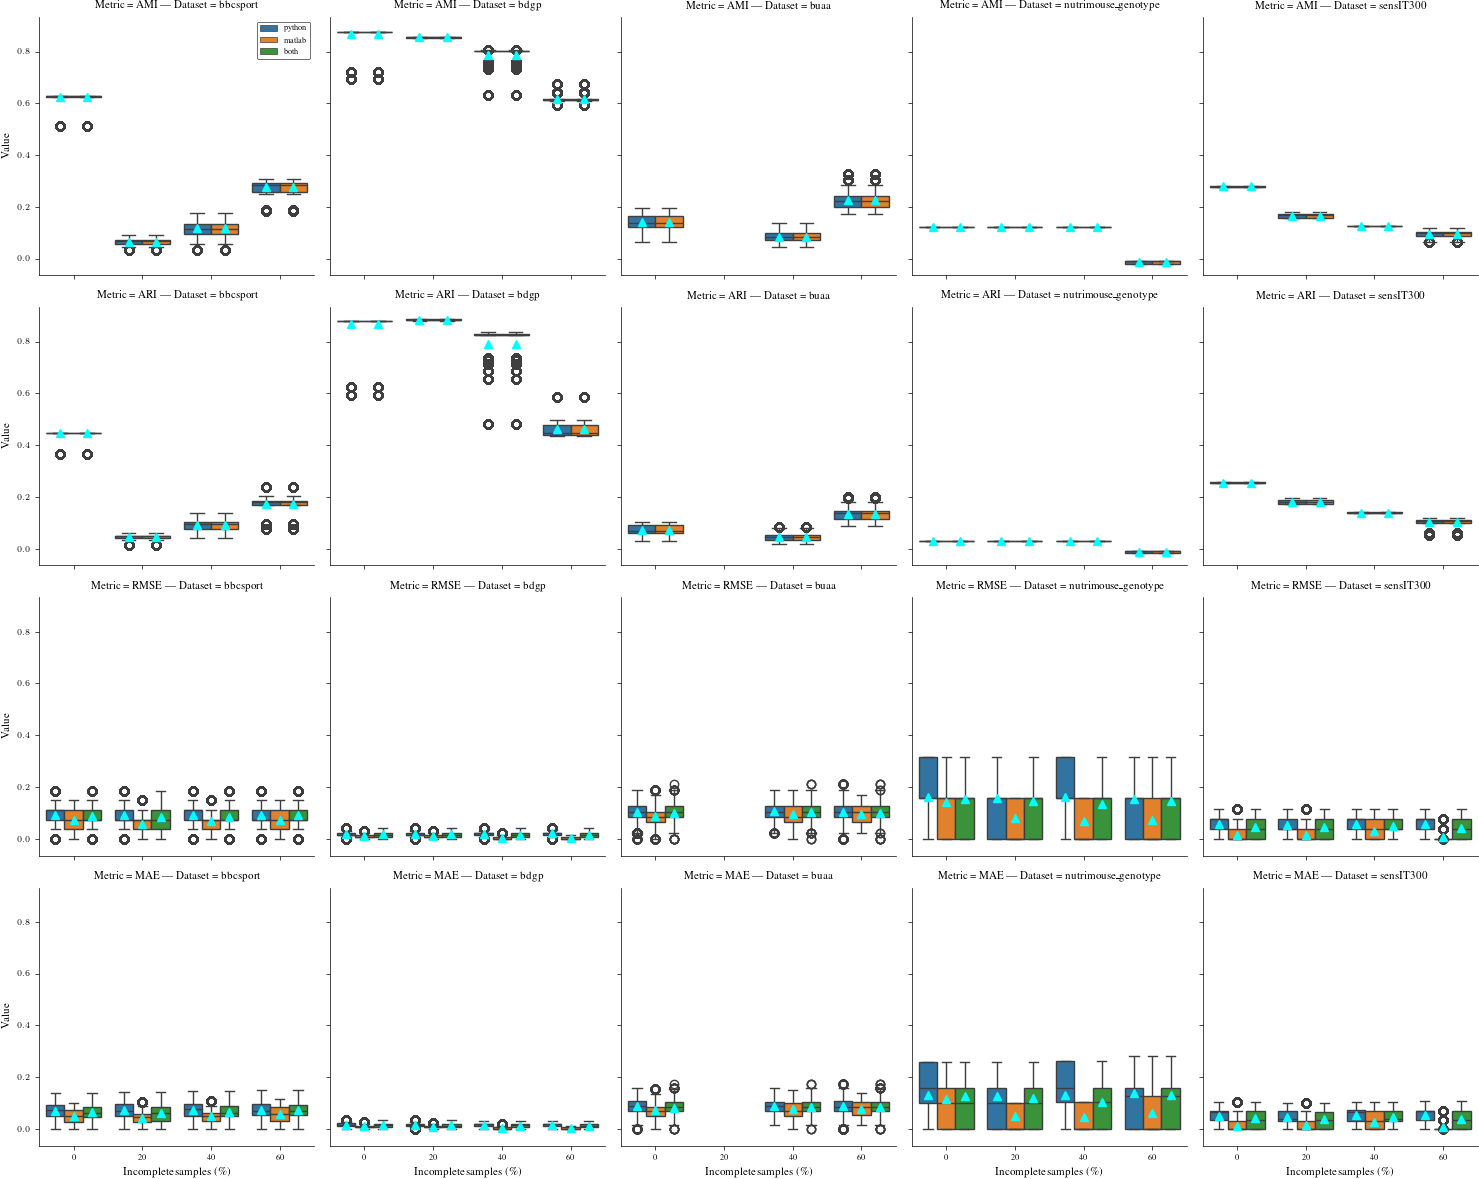

In [12]:
ax = sns.FacetGrid(data=results, row="Metric", col= "Dataset", dropna=True, legend_out=False, sharey=True).map_dataframe(
    sns.boxplot, x="Incomplete samples (\%)", y= "Value", hue= "Engine", palette= "tab10", showmeans=True, meanprops={'markerfacecolor':'cyan', 'markeredgecolor':'cyan'})
ax.add_legend()
plt.savefig(f"engine_comparison_ISMR.pdf")